# Latency and capacity estimation for a network connection from asymmetric measurements

In [184]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import urllib
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

## FIRST DATA SET

In [185]:
url = 'http://mescal.imag.fr/membres/arnaud.legrand/teaching/2014/RICM4_EP_ping/liglab2.log.gz'
urllib.request.urlretrieve(url, '/tmp/liglab2.log.gz')
os.system('gunzip /tmp/liglab2.log.gz')
os.system('sed -e "s/\[/ /"  -e "s/]/,/" -e "s/bytes.*time=/,/" -e "s/ms/ /" /tmp/liglab2.log > /tmp/ping_campus.log')
raw_data = pd.read_table("/tmp/ping_campus.log", header=None, sep=',', engine='python')

In [186]:
raw_data.columns = ['time', 'bytes','transmission_time']
raw_data

,time,bytes,transmission_time
0,1.421762e+09,665,22.50
1,1.421762e+09,1373,21.20
2,1.421762e+09,262,21.20
3,1.421762e+09,1107,23.30
4,1.421762e+09,1128,1.41
...,...,...,...
44408,1.421771e+09,1338,1.47
44409,1.421771e+09,1515,7.02
44410,1.421771e+09,1875,2.33
44411,1.421771e+09,1006,1.61


We will now look if we have missing data

In [187]:
raw_data[raw_data.isnull().any(axis=1)]

,time,bytes,transmission_time
12,1.421762e+09,21 bytes from lig-publig.imag.fr (129.88.11.7...,NaN
116,1.421762e+09,9 bytes from lig-publig.imag.fr (129.88.11.7)...,NaN
314,1.421762e+09,9 bytes from lig-publig.imag.fr (129.88.11.7)...,NaN
508,1.421762e+09,9 bytes from lig-publig.imag.fr (129.88.11.7)...,NaN
590,1.421762e+09,18 bytes from lig-publig.imag.fr (129.88.11.7...,NaN
...,...,...,...
43730,1.421771e+09,14 bytes from lig-publig.imag.fr (129.88.11.7...,NaN
43985,1.421771e+09,12 bytes from lig-publig.imag.fr (129.88.11.7...,NaN
44024,1.421771e+09,8 bytes from lig-publig.imag.fr (129.88.11.7)...,NaN
44170,1.421771e+09,8 bytes from lig-publig.imag.fr (129.88.11.7)...,NaN


We can see that we have 337 lines where the transmission time is missing. We will delete them.

In [188]:
data = raw_data.dropna().copy()
data = data.reset_index(drop = True)

We need to convert the time and transmission_time in float to use them.

In [189]:
data['time'] = data['time'].astype(float)
data['transmission_time'] = data['transmission_time'].astype(float)
data['bytes'] = data['bytes'].astype(int)

### <u>Question 1/</u>

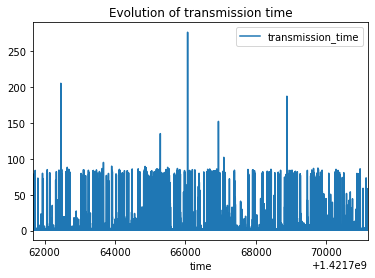

In [190]:
data.plot(x='time', y='transmission_time', title="Evolution of transmission time")

This is not really readable. We will take a different time scale to have a better view of the data.

In [191]:
(data['time'][44035] - data['time'][0]) / 3600

2.6402189027600818

The difference time between the first byte sent and the last one is about 2,6 hours. We will plot only the first quarter of the data to see what it looks like.

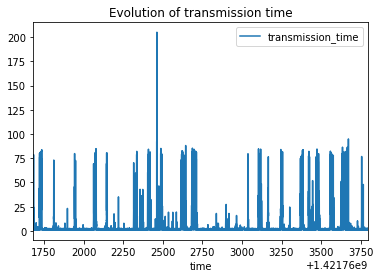

In [192]:
data[0:10000].plot(x='time', y='transmission_time', title="Evolution of transmission time")

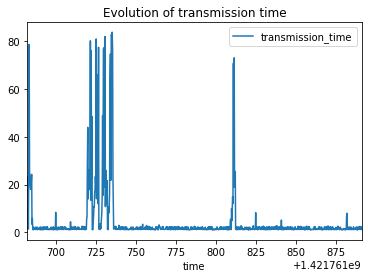

In [193]:
data[0:1000].plot(x='time', y='transmission_time', title="Evolution of transmission time")

We can not say yet why we have this kind of graphic. Is the variations of time only depend on the size of the packet? To answer, we need to continue our analysis.

### <u>Question 2/</u>

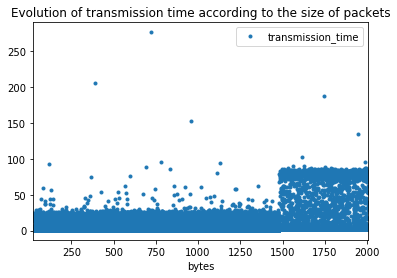

In [194]:
data.plot(x='bytes', y='transmission_time', title="Evolution of transmission time according to the size of packets", style='.')

We observe a "disruption" when the packet size is more than 1500 bytes. For packets whose size is between 0 and 1500 bytes, the transmission time is more or less between 0 and 25 ms. But when the size of the packets is bigger than 1500 bytes, the transmission time could reach at least 85 ms.

### <u>Question 3/</u>

If we zoom, we can see that the limitation between the two part is at 1480 bytes. We will take this value for the next questions.

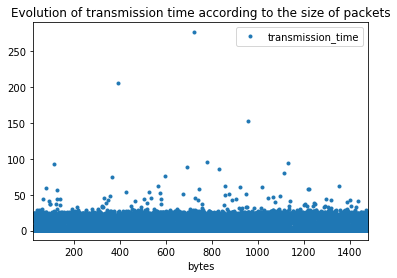

In [195]:
data_1 = data.query('bytes <= 1480')
data_1 = data_1.reset_index(drop = True)
data_1.plot(x='bytes', y='transmission_time', title="Evolution of transmission time according to the size of packets", style='.')

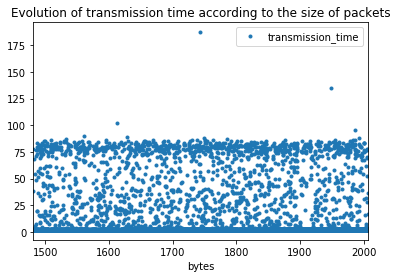

In [196]:
data_2 = data.query('bytes > 1480')
data_2 = data_2.reset_index(drop = True)
data_2.plot(x='bytes', y='transmission_time', title="Evolution of transmission time according to the size of packets", style='.')

### Linear regression data 1 with sklearn

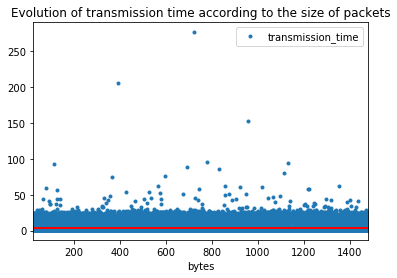

In [197]:
linear_regressor = LinearRegression()
linear_regressor.fit(data_1['bytes'].values.reshape(-1, 1), data_1['transmission_time'].values.reshape(-1, 1))
Y_pred = linear_regressor.predict(data_1['bytes'].values.reshape(-1, 1))
data_1.plot(x='bytes', y='transmission_time', title="Evolution of transmission time according to the size of packets", style='.')
plt.plot(data_1['bytes'].values.reshape(-1, 1), Y_pred, color='red')

In [198]:
linear_regressor.coef_

array([[0.00032632]])

In [199]:
linear_regressor.intercept_

array([3.2756742])

As we plot $T(S) = L + \frac{S}{C}$, .coef_ corresponds to $\frac{1}{C}$ and .intercept_ corresponds to $L$.

$\frac{1}{C} = 0.00032406$ so $C = \frac{1}{0.00032406} = 3085.8482997$ bytes per sec

$L = 3.27680784$ ms

### Linear regression data 2 with sklearn

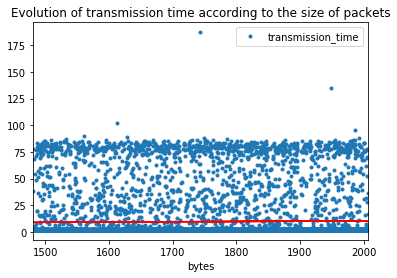

In [200]:
linear_regressor2 = LinearRegression()
linear_regressor2.fit(data_2['bytes'].values.reshape(-1, 1), data_2['transmission_time'].values.reshape(-1, 1))
Y_pred = linear_regressor2.predict(data_2['bytes'].values.reshape(-1, 1))
data_2.plot(x='bytes', y='transmission_time', title="Evolution of transmission time according to the size of packets", style='.')
plt.plot(data_2['bytes'].values.reshape(-1, 1), Y_pred, color='red')

In [201]:
linear_regressor2.coef_

array([[0.00257891]])

In [202]:
linear_regressor2.intercept_

array([5.28983257])

$\frac{1}{C} = 0.00265805$ so $C = \frac{1}{0.00265805} = 376.215646809$ bytes per sec

$L = 5.14486173$ ms

We can see that the capacity was divided by 10 and the latency is higher for the second part of the data. So when the packets are bigger, the performances decrease.

### Linear regression data 1 with statsmodels

In [203]:
X = data_1['bytes']
X = np.vander(X, 2)
y = data_1['transmission_time']
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      transmission_time   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     14.75
Date:                Sat, 11 Jan 2020   Prob (F-statistic):           0.000123
Time:                        16:27:50   Log-Likelihood:            -1.0715e+05
No. Observations:               32667   AIC:                         2.143e+05
Df Residuals:                   32665   BIC:                         2.143e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0003    8.5e-05      3.841      0.000       0.000       0.000
const          3.2757      0.072     45.301      0.000       3.134       3.417
==============================================================================
Omnibus:                    41906.256   Durbin-Watson:                   0.637
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         31002700.511
Skew:                           6.581   Prob(JB):                         0.00
Kurtosis:                     153.346   Cond. No.                     1.73e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The linear regression with statsmodels doesn't include an intercept by default like scikit-learn does. Without the line "np.vander(X,2)", we would obtain only one coef but we do not want that. That is why we use numpy.vander.

### Linear regression data 2 with statsmodels

In [204]:
X2 = data_2['bytes']
X2 = np.vander(X2, 2)
y2 = data_2['transmission_time']
model2 = sm.OLS(y2, X2)
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      transmission_time   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.050
Date:                Sat, 11 Jan 2020   Prob (F-statistic):             0.0442
Time:                        16:27:50   Log-Likelihood:                -50605.
No. Observations:               11369   AIC:                         1.012e+05
Df Residuals:                   11367   BIC:                         1.012e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0026      0.001      2.012      0.044     6.7e-05       0.005
const          5.2898      2.244      2.357      0.018       0.891       9.689
==============================================================================
Omnibus:                     6230.343   Durbin-Watson:                   0.677
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33724.913
Skew:                           2.764   Prob(JB):                         0.00
Kurtosis:                       9.374   Cond. No.                     2.02e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

I have done the linear regression with two different technics. At the end we see that we have more or less the same coefficients (x1 coef $= a$ and const coef $= b$ in $ax+b$ for statsmodels). However, we can display more information with statsmodels and we can clearly see that $R^2$ is equal to zero for the two part of the data, so the linear regression is irrelevant.

### <u>Question 4/</u>

Quantile regression is less sensitive to outliers.

### Quantile regression with statsmodels for data 1

In [205]:
mod = smf.quantreg('transmission_time ~ bytes', data_1)
res = mod.fit(q=.5)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:      transmission_time   Pseudo R-squared:              0.01608
Model:                       QuantReg   Bandwidth:                     0.01690
Method:                 Least Squares   Sparsity:                       0.2208
Date:                Sat, 11 Jan 2020   No. Observations:                32667
Time:                        16:27:51   Df Residuals:                    32665
                                        Df Model:                            1
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1391      0.001    917.622      0.000       1.137       1.142
bytes          0.0002   1.46e-06    169.697      0.000       0.000       0.000
==============================================================================

The condition number is large, 1.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

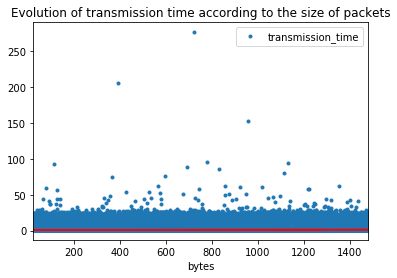

In [206]:
data_1.plot(x='bytes', y='transmission_time', title="Evolution of transmission time according to the size of packets", style='.')
calculate_y_quantile = lambda a, b: a * data_1['bytes'] + b
y_quantile = calculate_y_quantile(0.0002, 1.1391)
plt.plot(data_1['bytes'], y_quantile, color='red')

### Quantile regression with statsmodels for data 2

In [207]:
mod2 = smf.quantreg('transmission_time ~ bytes', data_2)
res2 = mod2.fit(q=.5)
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:      transmission_time   Pseudo R-squared:            0.0006425
Model:                       QuantReg   Bandwidth:                     0.02975
Method:                 Least Squares   Sparsity:                       0.2717
Date:                Sat, 11 Jan 2020   No. Observations:                11369
Time:                        16:27:51   Df Residuals:                    11367
                                        Df Model:                            1
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8857      0.015    128.324      0.000       1.857       1.915
bytes          0.0002   8.39e-06     29.366      0.000       0.000       0.000
==============================================================================

The condition number is large, 2.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

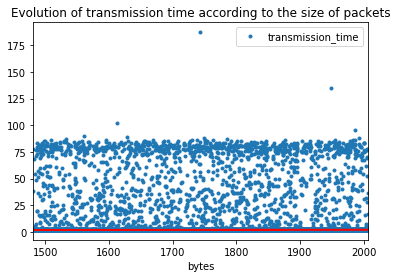

In [208]:
data_2.plot(x='bytes', y='transmission_time', title="Evolution of transmission time according to the size of packets", style='.')
calculate_y2_quantile = lambda a, b: a * data_2['bytes'] + b
y2_quantile = calculate_y2_quantile(0.0002, 1.8843)
plt.plot(data_2['bytes'], y2_quantile, color='red')

The intercept is lower in both data set 1 and 2 with the quantile regression method. This method is based on the mediane (I choose $q=0.5$), we have then a regression more precise.

### Other method : smallest transmission times

### Linear regression on data_1

In [209]:
dic = {}
for index, row in data_1.iterrows():
    if row['bytes'] not in dic:
        dic[row['bytes']] = [row['transmission_time']]
    else:
        dic[row['bytes']].append(row['transmission_time'])

for key, value in dic.items():
    dic[key] = min(value)

x_bytes = dic.keys()
x_bytes = [int(i) for i in x_bytes]
y_min_time = dic.values()
y_min_time = [float(j) for j in y_min_time]

In [210]:
X_reg = x_bytes
X_reg = np.vander(X_reg, 2)
y_reg = y_min_time
model_reg = sm.OLS(y_reg, X_reg)
results_reg = model_reg.fit()
results_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                 2.285e+04
Date:                Sat, 11 Jan 2020   Prob (F-statistic):               0.00
Time:                        16:27:53   Log-Likelihood:                 3297.7
No. Observations:                1457   AIC:                            -6591.
Df Residuals:                    1455   BIC:                            -6581.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0002   1.57e-06    151.152      0.000       0.000       0.000
const          1.0334      0.001    764.634      0.000       1.031       1.036
==============================================================================
Omnibus:                       26.475   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.695
Skew:                          -0.177   Prob(JB):                     2.40e-09
Kurtosis:                       3.727   Cond. No.                     1.77e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.77e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

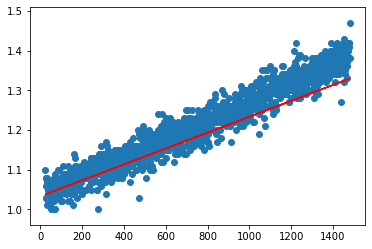

In [211]:
plt.scatter(x_bytes, y_min_time)
y_linear_reg = []
for x in x_bytes:
    y_linear_reg.append(0.0002 * x + 1.0334)
plt.plot(x_bytes, y_linear_reg, color='red')

### Linear regression on data_2

In [212]:
dic = {}
for index, row in data_2.iterrows():
    if row['bytes'] not in dic:
        dic[row['bytes']] = [row['transmission_time']]
    else:
        dic[row['bytes']].append(row['transmission_time'])

for key, value in dic.items():
    dic[key] = min(value)

x_bytes = dic.keys()
x_bytes = [int(i) for i in x_bytes]
y_min_time = dic.values()
y_min_time = [float(j) for j in y_min_time]

In [213]:
X_reg = x_bytes
X_reg = np.vander(X_reg, 2)
y_reg = y_min_time
model_reg = sm.OLS(y_reg, X_reg)
results_reg = model_reg.fit()
results_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     730.4
Date:                Sat, 11 Jan 2020   Prob (F-statistic):          1.86e-101
Time:                        16:27:54   Log-Likelihood:                 1079.5
No. Observations:                 527   AIC:                            -2155.
Df Residuals:                     525   BIC:                            -2146.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0002   8.95e-06     27.026      0.000       0.000       0.000
const          1.7432      0.016    111.250      0.000       1.712       1.774
==============================================================================
Omnibus:                        0.206   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.902   Jarque-Bera (JB):                0.275
Skew:                           0.043   Prob(JB):                        0.872
Kurtosis:                       2.928   Cond. No.                     2.01e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.01e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

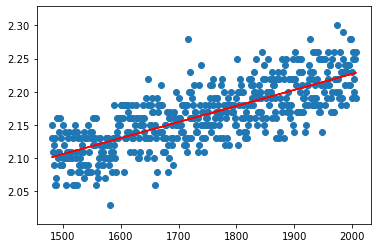

In [214]:
plt.scatter(x_bytes, y_min_time)
pred = model_reg.fit().predict(X_reg)
plt.plot(x_bytes, pred, color='red')

To plot the red line, I tried a different method which is finally simplier. I do not know why but when I tried my previous method (when I calculate for the for loop each point of the red line), it plot the previous red line (previous vector still in memory?).

When we select the smallest transmission time for each bytes, we can clearly see that when the number of bytes increase, the transmission time also increase linearly. Now the linear regression is more relevant.

## SECOND DATA SET

In [215]:
url = 'http://mescal.imag.fr/membres/arnaud.legrand/teaching/2014/RICM4_EP_ping/stackoverflow.log.gz'
urllib.request.urlretrieve(url, '/tmp/stackoverflow.log.gz')
os.system('gunzip /tmp/stackoverflow.log.gz')
os.system('sed -e "s/\[/ /"  -e "s/]/,/" -e "s/bytes.*time=/,/" -e "s/ms/ /" /tmp/stackoverflow.log > /tmp/ping_stackoverflow.log')
raw_data_bis = pd.read_table("/tmp/ping_stackoverflow.log", header=None, sep=',', engine='python')

In [216]:
raw_data_bis.columns = ['time', 'bytes', 'transmission_time']
raw_data_bis

,time,bytes,transmission_time
0,1.421771e+09,1257,120.0
1,1.421771e+09,454,120.0
2,1.421771e+09,775,126.0
3,1.421771e+09,1334,112.0
4,1.421771e+09,83,111.0
...,...,...,...
6882,1.421773e+09,1696,111.0
6883,1.421773e+09,561,111.0
6884,1.421773e+09,773,111.0
6885,1.421773e+09,1009,111.0


Missing data?

In [217]:
raw_data_bis[raw_data_bis.isnull().any(axis=1)]

,time,bytes,transmission_time
56,1.421771e+09,12 bytes from stackoverflow.com (198.252.206....,NaN
136,1.421771e+09,22 bytes from stackoverflow.com (198.252.206....,NaN
331,1.421771e+09,11 bytes from stackoverflow.com (198.252.206....,NaN
379,1.421771e+09,22 bytes from stackoverflow.com (198.252.206....,NaN
414,1.421771e+09,16 bytes from stackoverflow.com (198.252.206....,NaN
...,...,...,...
6356,1.421773e+09,13 bytes from stackoverflow.com (198.252.206....,NaN
6482,1.421773e+09,10 bytes from stackoverflow.com (198.252.206....,NaN
6499,1.421773e+09,8 bytes from stackoverflow.com (198.252.206.1...,NaN
6543,1.421773e+09,17 bytes from stackoverflow.com (198.252.206....,NaN


In [218]:
data_bis = raw_data_bis.dropna().copy()
data_bis = data_bis.reset_index(drop = True)

In [219]:
data_bis['time'] = data_bis['time'].astype(float)
data_bis['transmission_time'] = data_bis['transmission_time'].astype(float)
data_bis['bytes'] = data_bis['bytes'].astype(int)

### <u>Question 1/</u>

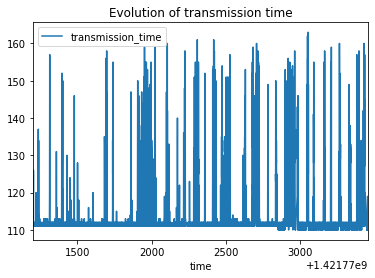

In [220]:
data_bis.plot(x='time', y='transmission_time', title="Evolution of transmission time")

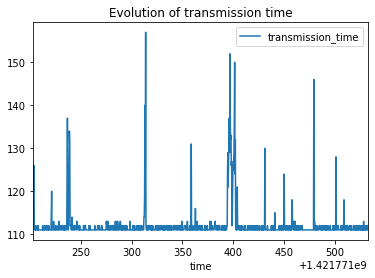

In [221]:
data_bis[0:1000].plot(x='time', y='transmission_time', title="Evolution of transmission time")

If we compare it to the first data set, we have much more variations in the second data set. We have to plot the transmission time as a function of message size to see if there is a link between the both.

### <u>Question 2/</u>

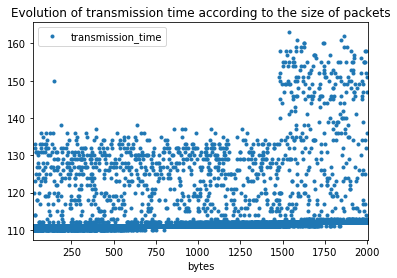

In [222]:
data_bis.plot(x='bytes', y='transmission_time', title="Evolution of transmission time according to the size of packets", style='.')

As for the first data set, we notice a variation at 1500 bytes. The first part of the data are between 110 and 135 ms and the second part of the data are between 110 and 160 ms

### <u>Question 3/</u>

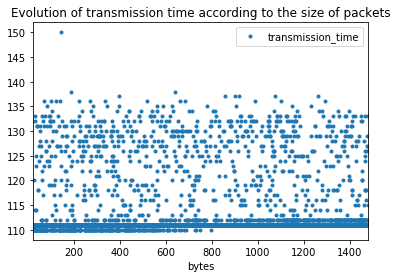

In [223]:
data_bis_1 = data_bis.query('bytes < 1480')
data_bis_1 = data_bis_1.reset_index(drop = True)
data_bis_1.plot(x='bytes', y='transmission_time', title="Evolution of transmission time according to the size of packets", style='.')

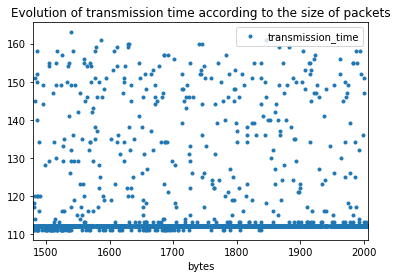

In [224]:
data_bis_2 = data_bis.query('bytes >= 1480')
data_bis_2 = data_bis_2.reset_index(drop = True)
data_bis_2.plot(x='bytes', y='transmission_time', title="Evolution of transmission time according to the size of packets", style='.')

### Linear regression with sklearn

#### Data : first part

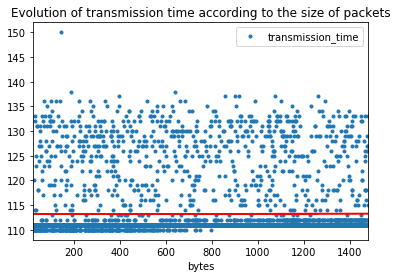

In [225]:
linear_regressor = LinearRegression()
linear_regressor.fit(data_bis_1['bytes'].values.reshape(-1, 1), data_bis_1['transmission_time'].values.reshape(-1, 1))
Y_pred = linear_regressor.predict(data_bis_1['bytes'].values.reshape(-1, 1))
data_bis_1.plot(x='bytes', y='transmission_time', title="Evolution of transmission time according to the size of packets", style='.')
plt.plot(data_bis_1['bytes'].values.reshape(-1, 1), Y_pred, color='red')

In [226]:
linear_regressor.coef_

array([[5.19357942e-05]])

In [227]:
linear_regressor.intercept_

array([113.22416074])

$\frac{1}{C} = 5.19357942e^{-05}$ so $C = \frac{1}{5.19357942e^{-05}} = 19254.5433338$ bytes per sec

$L = 113.22416074$ ms

#### Data : second part

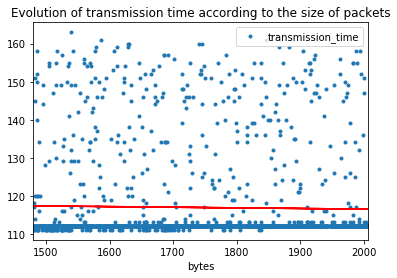

In [228]:
linear_regressor2 = LinearRegression()
linear_regressor2.fit(data_bis_2['bytes'].values.reshape(-1, 1), data_bis_2['transmission_time'].values.reshape(-1, 1))
Y_pred = linear_regressor2.predict(data_bis_2['bytes'].values.reshape(-1, 1))
data_bis_2.plot(x='bytes', y='transmission_time', title="Evolution of transmission time according to the size of packets", style='.')
plt.plot(data_bis_2['bytes'].values.reshape(-1, 1), Y_pred, color='red')

In [229]:
linear_regressor2.coef_

array([[-0.00165408]])

In [230]:
linear_regressor2.intercept_

array([119.78137995])

$\frac{1}{C} = 0.00165408$ so $C = \frac{1}{0.00165408} = 604.565680015$ bytes per sec

$L = 119.78137995$ ms

### Linear regression with statsmodels

#### Data : first part

In [231]:
X_bis = data_bis_1['bytes']
X_bis = np.vander(X_bis, 2)
y_bis = data_bis_1['transmission_time']
model = sm.OLS(y_bis, X_bis)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      transmission_time   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.07159
Date:                Sat, 11 Jan 2020   Prob (F-statistic):              0.789
Time:                        16:27:56   Log-Likelihood:                -15935.
No. Observations:                5011   AIC:                         3.187e+04
Df Residuals:                    5009   BIC:                         3.189e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          5.194e-05      0.000      0.268      0.789      -0.000       0.000
const        113.2242      0.166    683.713      0.000     112.900     113.549
==============================================================================
Omnibus:                     2444.253   Durbin-Watson:                   0.488
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10403.607
Skew:                           2.499   Prob(JB):                         0.00
Kurtosis:                       7.986   Cond. No.                     1.72e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Data : second part

In [232]:
X_bis_2 = data_bis_2['bytes']
X_bis_2 = np.vander(X_bis_2, 2)
y_bis_2 = data_bis_2['transmission_time']
model2 = sm.OLS(y_bis_2, X_bis_2)
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      transmission_time   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8263
Date:                Sat, 11 Jan 2020   Prob (F-statistic):              0.363
Time:                        16:27:56   Log-Likelihood:                -7057.6
No. Observations:                1813   AIC:                         1.412e+04
Df Residuals:                    1811   BIC:                         1.413e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0017      0.002     -0.909      0.363      -0.005       0.002
const        119.7814      3.175     37.723      0.000     113.554     126.009
==============================================================================
Omnibus:                      825.791   Durbin-Watson:                   0.742
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2981.833
Skew:                           2.354   Prob(JB):                         0.00
Kurtosis:                       7.161   Cond. No.                     1.99e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.99e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As for the first data set, we have more or the less the same coefficients.

### <u>Question 4/</u>

### Quantile regression with statsmodels

#### Data : First part

In [233]:
mod = smf.quantreg('transmission_time ~ bytes', data_bis_1)
res = mod.fit(q=.5)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:      transmission_time   Pseudo R-squared:           -9.356e-08
Model:                       QuantReg   Bandwidth:                   1.557e-07
Method:                 Least Squares   Sparsity:                    1.525e-06
Date:                Sat, 11 Jan 2020   No. Observations:                 5011
Time:                        16:27:56   Df Residuals:                     5009
                                        Df Model:                            1
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    111.0000   2.17e-08   5.12e+09      0.000     111.000     111.000
bytes       7.546e-10   2.54e-11     29.682      0.000    7.05e-10    8.04e-10
==============================================================================

The condition number is large, 1.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

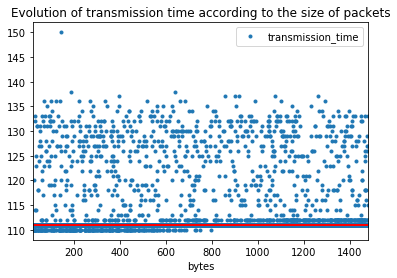

In [234]:
data_bis_1.plot(x='bytes', y='transmission_time', title="Evolution of transmission time according to the size of packets", style='.')
calculate_y_quantile = lambda a, b: a * data_bis_1['bytes'] + b
y_quantile = calculate_y_quantile(7.546e-10, 111.0000)
plt.plot(data_bis_1['bytes'], y_quantile, color='red')

#### Data : second part

In [235]:
mod2 = smf.quantreg('transmission_time ~ bytes', data_bis_2)
res2 = mod2.fit(q=.5)
res2.summary()

/usr/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/usr/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/usr/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:      transmission_time   Pseudo R-squared:           -2.697e-08
Model:                       QuantReg   Bandwidth:                   2.262e-08
Method:                 Least Squares   Sparsity:                          inf
Date:                Sat, 11 Jan 2020   No. Observations:                 1813
Time:                        16:27:57   Df Residuals:                     1811
                                        Df Model:                            1
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    112.0000        nan        nan        nan         nan         nan
bytes       2.129e-10        nan        nan        nan         nan         nan
==============================================================================

The condition number is large, 1.99e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now we have a problem : <b>division by zero</b>. 

This is due to the coefficient of the line which is too close to zero and thus the program cannot compute the values.

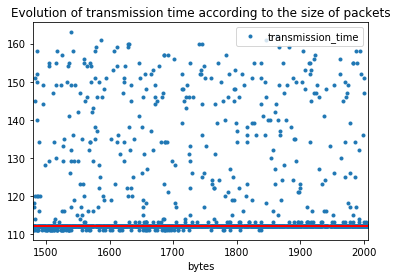

In [236]:
data_bis_2.plot(x='bytes', y='transmission_time', title="Evolution of transmission time according to the size of packets", style='.')
calculate_y_quantile = lambda a, b: a * data_bis_2['bytes'] + b
y_quantile = calculate_y_quantile( 2.129e-10, 112.0000)
plt.plot(data_bis_2['bytes'], y_quantile, color='red')

As for the first data set, the intercept are lower with the quantile regression.

### Other method : smallest transmission times

### Linear Regression : first part

In [237]:
dic = {}
for index, row in data_bis_1.iterrows():
    if row['bytes'] not in dic:
        dic[row['bytes']] = [row['transmission_time']]
    else:
        dic[row['bytes']].append(row['transmission_time'])

for key, value in dic.items():
    dic[key] = min(value)

x_bytes = dic.keys()
x_bytes = [int(i) for i in x_bytes]
y_min_time = dic.values()
y_min_time = [float(j) for j in y_min_time]

In [238]:
X_reg = x_bytes
X_reg = np.vander(X_reg, 2)
y_reg = y_min_time
model_reg = sm.OLS(y_reg, X_reg)
results_reg = model_reg.fit()
results_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     6.958
Date:                Sat, 11 Jan 2020   Prob (F-statistic):            0.00844
Time:                        16:27:58   Log-Likelihood:                -3061.3
No. Observations:                1409   AIC:                             6127.
Df Residuals:                    1407   BIC:                             6137.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0004      0.000      2.638      0.008    9.08e-05       0.001
const        110.8804      0.116    959.201      0.000     110.654     111.107
==============================================================================
Omnibus:                     1934.213   Durbin-Watson:                   1.857
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           268906.696
Skew:                           7.912   Prob(JB):                         0.00
Kurtosis:                      68.803   Cond. No.                     1.76e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.76e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

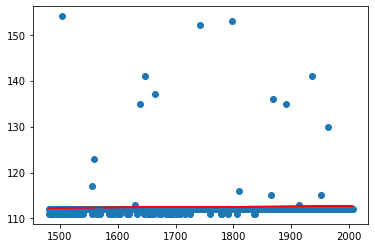

In [245]:
plt.scatter(x_bytes, y_min_time)
pred = model_reg.fit().predict(X_reg)
plt.plot(x_bytes, pred, color='red')

### Linear Regression : second part

In [240]:
dic = {}
for index, row in data_bis_2.iterrows():
    if row['bytes'] not in dic:
        dic[row['bytes']] = [row['transmission_time']]
    else:
        dic[row['bytes']].append(row['transmission_time'])

for key, value in dic.items():
    dic[key] = min(value)

x_bytes = dic.keys()
x_bytes = [int(i) for i in x_bytes]
y_min_time = dic.values()
y_min_time = [float(j) for j in y_min_time]

In [241]:
X_reg = x_bytes
X_reg = np.vander(X_reg, 2)
y_reg = y_min_time
model_reg = sm.OLS(y_reg, X_reg)
results_reg = model_reg.fit()
results_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3388
Date:                Sat, 11 Jan 2020   Prob (F-statistic):              0.561
Time:                        16:27:58   Log-Likelihood:                -1460.2
No. Observations:                 507   AIC:                             2924.
Df Residuals:                     505   BIC:                             2933.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0007      0.001      0.582      0.561      -0.002       0.003
const        111.2181      2.219     50.119      0.000     106.858     115.578
==============================================================================
Omnibus:                      705.179   Durbin-Watson:                   1.553
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            76245.877
Skew:                           7.457   Prob(JB):                         0.00
Kurtosis:                      61.196   Cond. No.                     2.02e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

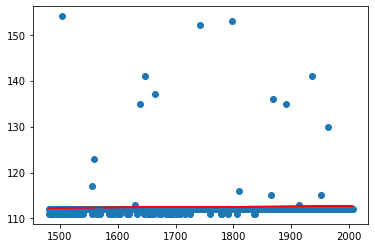

In [244]:
plt.scatter(x_bytes, y_min_time)
pred = model_reg.fit().predict(X_reg)
plt.plot(x_bytes, pred, color='red')

We have lots more outliers in this data set. Even if we take the minimum of transmission time of each bytes, we still have lots of variations. But the linear regression shows that when the number of bytes increases, the transmission time seems to increase too.

# Conclusion

This two data set were a good training to implement a <b>Reproducible Research</b>. There were well structured and easy to use. I have learned usefull tricks in Python and I will definitely use Jupyter Notebook in my future life as a researcher.